In [1]:
import re

from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
df_eco = pd.read_csv("dataset/economy.csv", thousands=',')
df_biz = pd.read_csv("dataset/business.csv", thousands=',')

In [3]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        206774 non-null  object
 1   airline     206774 non-null  object
 2   ch_code     206774 non-null  object
 3   num_code    206774 non-null  int64 
 4   dep_time    206774 non-null  object
 5   from        206774 non-null  object
 6   time_taken  206774 non-null  object
 7   stop        206774 non-null  object
 8   arr_time    206774 non-null  object
 9   to          206774 non-null  object
 10  price       206774 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.4+ MB


In [4]:
df_biz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 7.8+ MB


In [5]:
df_eco.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955


In [6]:
def rename_columns(df):
    df.rename(
        columns={
            "from": "source_city",
            "to": "destination_city",
            "dep_time": "departure_time",
            "arr_time": "arrival_time"
        },
        inplace=True
    )

In [7]:
def create_days_left_feature(df):
    df.date = pd.to_datetime(df.date, format="%d-%m-%Y")
    booking_date = df.date.min() - pd.Timedelta(days=1)

    df["days_left"] = (df.date - booking_date).dt.days

In [8]:
def create_flight_feature(df):
    df["flight"] = df_eco.ch_code + "-" + df_eco.num_code.astype(str)

    return df

In [9]:
def create_departure_feature(df):
    cols = ["departure_time_hr", "departure_time_min"]

    df[cols] = df.departure_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

In [10]:
def create_arrival_feature(df):
    cols = ["arrival_time_hr", "arrival_time_min"]

    df[cols] = df.arrival_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

In [11]:
def create_duration_feature(df):
    def transform_time_taken(item):
        hour, minute = re.search("([\d.]*)h ([\d.]*)m", item).groups()

        return float(minute or 0) + float(hour or 0) * 60

    df["duration"] = df.time_taken.apply(transform_time_taken)

In [12]:
def create_via_feature(df):
    stops = []
    via_list = []

    for item in df.stop:
        item = re.sub("[\n\t]+", " ", item)
        stop, via = re.search("([\w+-]+)(?: Via (\w+))?", item).groups()

        if not via:
            via = "UNK"

        stops.append(stop)
        via_list.append(via)

    df["stops"] = pd.Series(stops)
    df["via"] = pd.Series(via_list)

In [13]:
def create_class_feature(df, class_):
    df["class"] = class_

In [14]:
df_eco_t = df_eco.copy()

rename_columns(df_eco_t)
create_days_left_feature(df_eco_t)
create_flight_feature(df_eco_t)
create_departure_feature(df_eco_t)
create_arrival_feature(df_eco_t)
create_duration_feature(df_eco_t)
create_via_feature(df_eco_t)
create_class_feature(df_eco_t, "Economy")

df_eco_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                206774 non-null  datetime64[ns]
 1   airline             206774 non-null  object        
 2   ch_code             206774 non-null  object        
 3   num_code            206774 non-null  int64         
 4   departure_time      206774 non-null  object        
 5   source_city         206774 non-null  object        
 6   time_taken          206774 non-null  object        
 7   stop                206774 non-null  object        
 8   arrival_time        206774 non-null  object        
 9   destination_city    206774 non-null  object        
 10  price               206774 non-null  int64         
 11  days_left           206774 non-null  int64         
 12  flight              206774 non-null  object        
 13  departure_time_hr   206774 no

In [15]:
df_biz_t = df_biz.copy()

rename_columns(df_biz_t)
create_days_left_feature(df_biz_t)
create_flight_feature(df_biz_t)
create_departure_feature(df_biz_t)
create_arrival_feature(df_biz_t)
create_duration_feature(df_biz_t)
create_via_feature(df_biz_t)
create_class_feature(df_biz_t, "Business")

df_biz_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                93487 non-null  datetime64[ns]
 1   airline             93487 non-null  object        
 2   ch_code             93487 non-null  object        
 3   num_code            93487 non-null  int64         
 4   departure_time      93487 non-null  object        
 5   source_city         93487 non-null  object        
 6   time_taken          93487 non-null  object        
 7   stop                93487 non-null  object        
 8   arrival_time        93487 non-null  object        
 9   destination_city    93487 non-null  object        
 10  price               93487 non-null  int64         
 11  days_left           93487 non-null  int64         
 12  flight              93487 non-null  object        
 13  departure_time_hr   93487 non-null  int64     

In [16]:
df = pd.concat([df_eco_t, df_biz_t])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300261 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                300261 non-null  datetime64[ns]
 1   airline             300261 non-null  object        
 2   ch_code             300261 non-null  object        
 3   num_code            300261 non-null  int64         
 4   departure_time      300261 non-null  object        
 5   source_city         300261 non-null  object        
 6   time_taken          300261 non-null  object        
 7   stop                300261 non-null  object        
 8   arrival_time        300261 non-null  object        
 9   destination_city    300261 non-null  object        
 10  price               300261 non-null  int64         
 11  days_left           300261 non-null  int64         
 12  flight              300261 non-null  object        
 13  departure_time_hr   300261 non-null

In [18]:
# Exclude ch_code, num_code, time_taken, departure_time, arrival_time, stop

categorical_features = [
    "date",
    "airline",
    "flight",
    "source_city",
    "destination_city",
    "stops",
    "via",
    "class"
]

numerical_features = [
    "days_left",
    "departure_time_hr",
    "departure_time_min",
    "arrival_time_hr",
    "arrival_time_min",
    "duration",
]

target = "price"

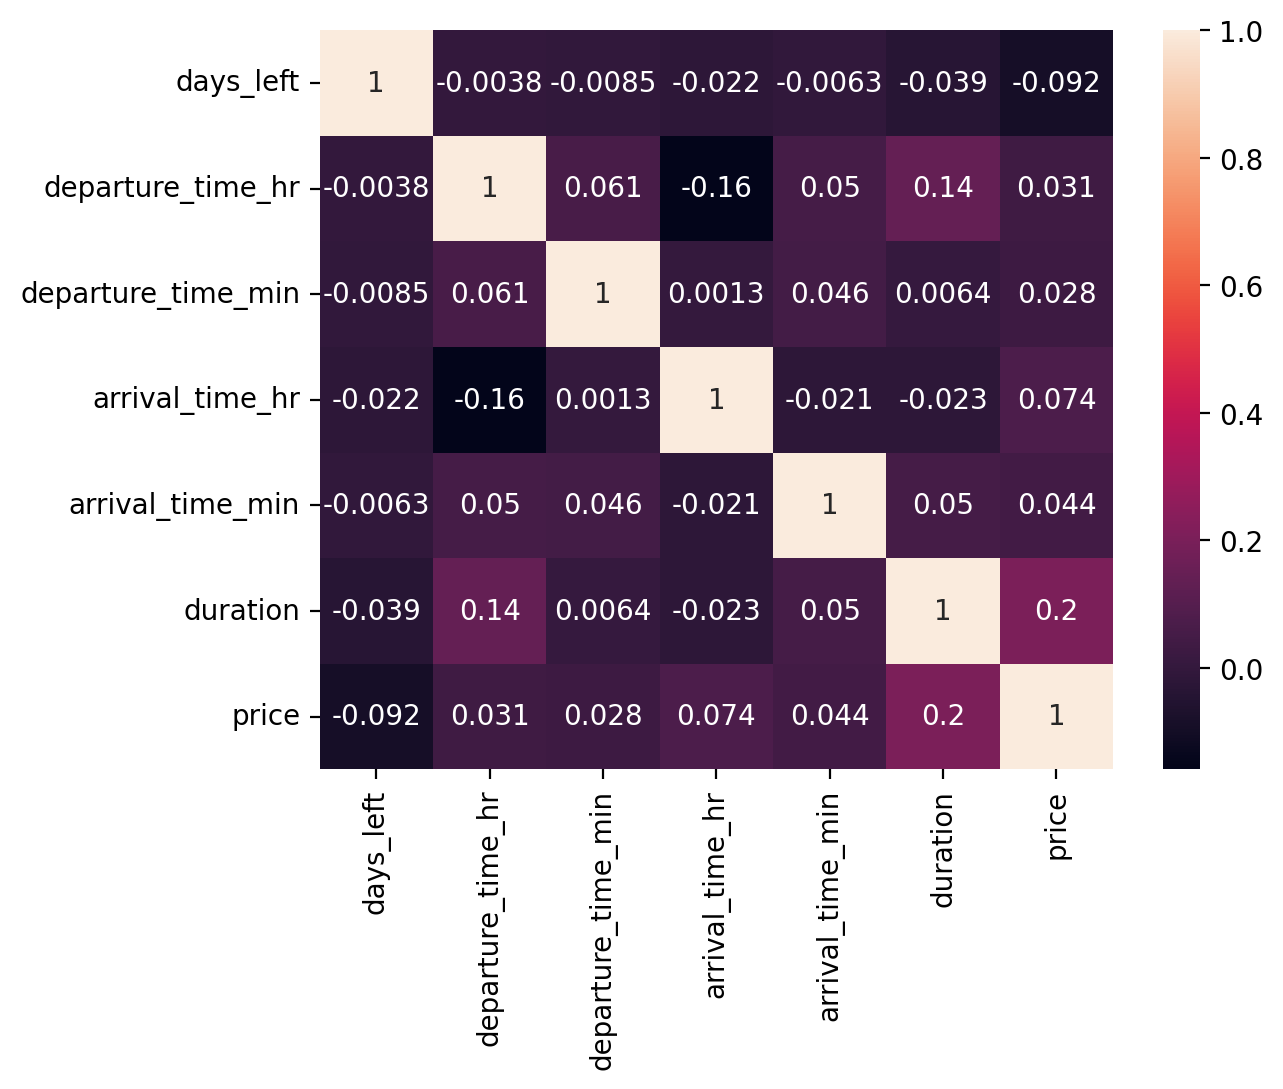

In [19]:
sns.heatmap(df[numerical_features + [target]].corr(), annot=True)
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != target],
    df[target]
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [21]:
X_train.shape

(202675, 20)

In [22]:
X_val.shape

(22520, 20)

In [23]:
X_test.shape

(75066, 20)

In [24]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train_cat = oe.fit_transform(X_train[categorical_features])

In [25]:
# Combine categorical and numerical features column-wise
X_train_mt = np.hstack((X_train_cat, X_train[numerical_features]))

In [26]:
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train_mt)

In [27]:
y_train_scaled = np.log1p(y_train)

In [28]:
model_names = [
    "Linear Regression",
    "Lasso",
    "Ridge",
    "ElasticNet",
    "SGD",
    "Decision Tree",
    "Random Forest"
]

models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    SGDRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_jobs=-1)
]

scores = []

In [29]:
for model in models:
    model.fit(X_train_scaled, y_train_scaled)

In [30]:
X_val_cat = oe.transform(X_val[categorical_features])
X_val_mt = np.hstack((X_val_cat, X_val[numerical_features]))
X_val_scaled = mm.transform(X_val_mt)

y_val_scaled = np.log1p(y_val)

X_test_cat = oe.transform(X_test[categorical_features])
X_test_mt = np.hstack((X_test_cat, X_test[numerical_features]))
X_test_scaled = mm.transform(X_test_mt)

y_test_scaled = np.log1p(y_test)

In [31]:
def evaluate(y_test, y_pred):
    return {
        "mae": mean_absolute_error(y_test, y_pred),
        "mape": mean_absolute_percentage_error(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred)
    }

In [32]:
for model in models:
    y_pred = np.expm1(model.predict(X_test_scaled))
    scores.append(evaluate(y_test, y_pred))

In [33]:
models[1].score(X_test_scaled, y_test_scaled)

-3.267394839134852e-07

In [34]:
scores_df = pd.DataFrame(scores)

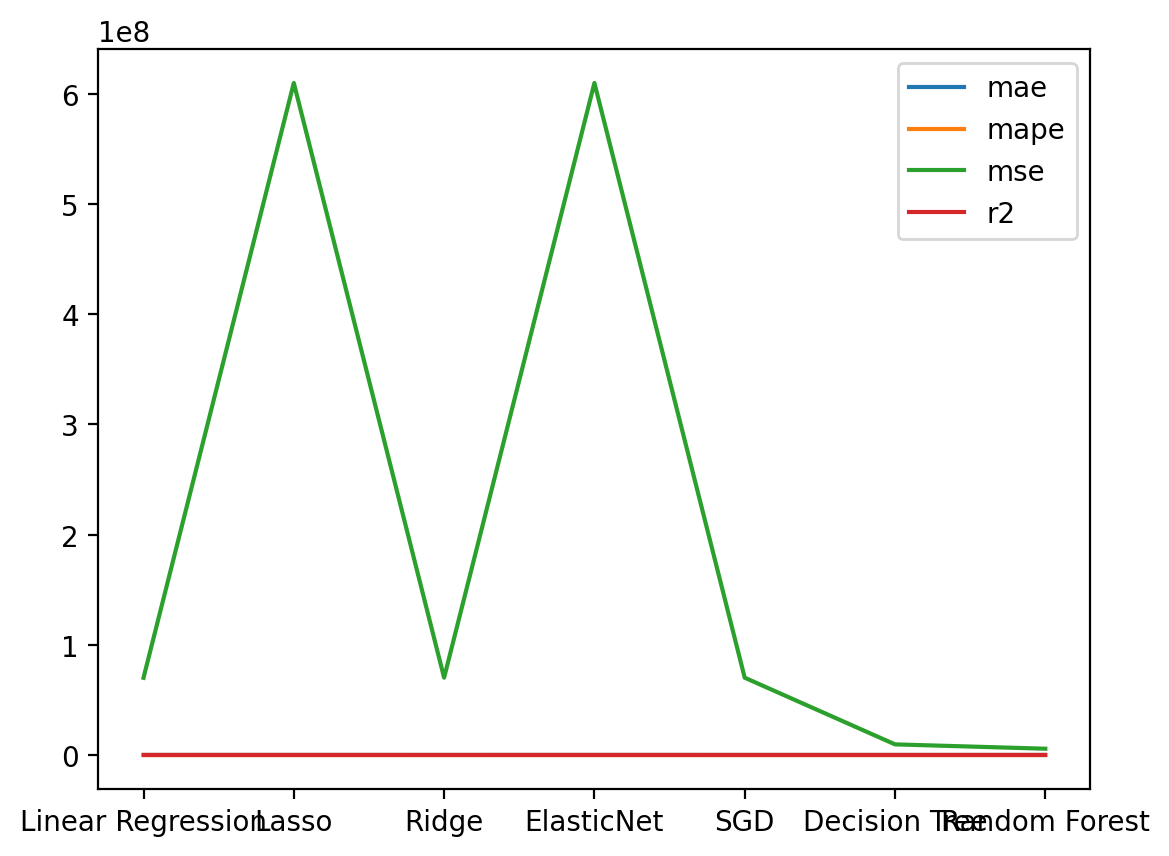

In [35]:
plt.plot(model_names, scores_df[["mae", "mape", "mse", "r2"]])
plt.legend(["mae", "mape", "mse", "r2"])
plt.show()

In [36]:
scores_df

,mae,mape,mse,r2
0,4929.870723,0.297179,7.004770e+07,0.864573
1,16633.798781,1.140855,6.099509e+08,-0.179255
2,4932.434651,0.297205,7.013943e+07,0.864395
3,16633.798781,1.140855,6.099509e+08,-0.179255
4,4930.984380,0.297211,7.011425e+07,0.864444
5,948.580520,0.059781,9.602659e+06,0.981435
6,893.115831,0.053737,5.664432e+06,0.989049


In [67]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform ("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight" : hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": hp.quniform("n_estimators", 100, 100000, 1),
    "seed": 0
}

In [68]:
def objective(space):
    print(space)

    model = XGBRegressor(
        early_stopping_rounds=10,
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space["reg_alpha"]),
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"]),
        n_estimators=int(space["n_estimators"])
    )

    model.fit(
        X_train_scaled,
        y_train_scaled,
        eval_set=[(X_val_scaled, y_val_scaled)],
        verbose=False
    )

    y_pred = model.predict(X_test_scaled)
    score = evaluate(y_pred, y_test_scaled)

    return {'loss': np.sqrt(score["mse"]), 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials
)

In [73]:
best_hyperparams_ = {
    "colsample_bytree": 0.8545834573974018,
    "gamma": 1.0149990564873104,
    "max_depth": 17.0,
    "min_child_weight": 8.0,
    "n_estimators": 5149.0,
    "reg_alpha": 40.0,
    "reg_lambda": 0.0008085443779402013
}

In [ ]:
model = XGBRegressor(
    # early_stopping_rounds=50,
    # tree_method="hist",
    # learning_rate=0.1,
    # n_estimators=1000,
    # max_depth=4,
    # min_child_weight=6,
    # gamma=0,
    # subsample=0.8,
    # colsample_bytree=0.8,
    n_jobs=-1
)

In [ ]:
model.fit(X_train_scaled, y_train_scaled)

In [ ]:
y_pred = np.expm1(model.predict(X_test_scaled))

In [ ]:
evaluate(y_pred, y_test)

In [ ]:
plot_importance(model)